In [14]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist
import imageio

from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI
from lib.analysis.align import ImageAlign
from lib.utilities import *
# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/03-18-24/converted_zda/04_01_01_amp_map.dat


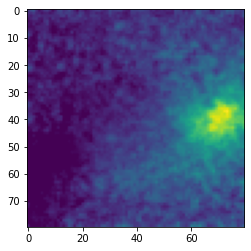

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/03-18-24/converted_zda/04_01_01_snr_map.dat


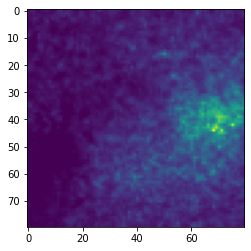

In [15]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/03-18-24/converted_zda/"
target_recording = '04_01_01'
red_rois_filename = data_dir + 'ROIs-red_' + target_recording + '.dat'
# input files: *_amp.dat, *_snr.dat   # do not normalize!
cluster_SNRcutoff = 1

ROI_px_cutoff = 9
SNR_cutoff = 10
Amp_cutoff = 1.4

data = {}
for fn in ['_amp_map.dat', '_snr_map.dat']:
    fn2 = data_dir + target_recording + fn
    print(fn2)
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr

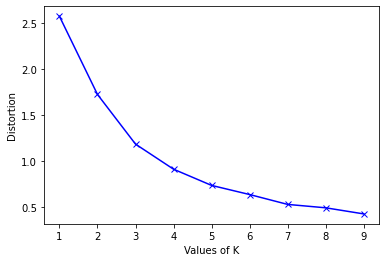

In [16]:
# elbow plot
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = data['_snr_map.dat'].reshape((-1,1))

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.show()

[[1 4 4 ... 4 4 4]
 [1 1 4 ... 4 4 0]
 [1 1 1 ... 1 4 4]
 ...
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 1]
 [1 1 1 ... 4 4 4]]


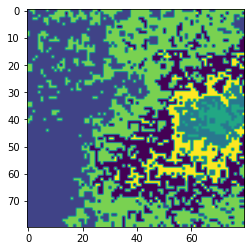

In [17]:
# Step1 produce: Density plot of SNR for all pixels,
#         K-means clustering plot of heatmap with cutoff applied
# Step2 produce: remove ROIs with diameters > cutoff

# K-means cluster on SNR data
k_choice = 6
km = KMeans(n_clusters=k_choice)
km.fit(data['_snr_map.dat'].reshape((-1,1)))
labels = km.predict(data['_snr_map.dat'].reshape((-1,1)))
labels = labels.reshape((80,80))
plt.imshow(labels)
print(labels)
plt.show()

[[1.25131  2.24237  2.4863   ... 2.3663   2.40135  2.08811 ]
 [1.21898  1.67821  2.15204  ... 2.61375  2.89809  4.25177 ]
 [0.919091 0.942237 1.70201  ... 1.70441  2.41165  3.73587 ]
 ...
 [0.       0.       0.279815 ... 2.34893  2.26663  2.04079 ]
 [0.       0.       0.       ... 3.14339  2.40112  1.57181 ]
 [0.727487 0.       0.       ... 1.87012  2.42432  2.16381 ]]
[[1.25131  2.24237  2.4863   ... 2.3663   2.40135  2.08811 ]
 [1.21898  1.67821  2.15204  ... 2.61375  2.89809  4.25177 ]
 [0.919091 0.942237 1.70201  ... 1.70441  2.41165  3.73587 ]
 ...
 [0.       0.       0.279815 ... 2.34893  2.26663  2.04079 ]
 [0.       0.       0.       ... 3.14339  2.40112  1.57181 ]
 [0.727487 0.       0.       ... 1.87012  2.42432  2.16381 ]]
[[1.25131  2.24237  2.4863   ... 2.3663   2.40135  2.08811 ]
 [1.21898  1.67821  2.15204  ... 2.61375  2.89809  4.25177 ]
 [0.919091 0.942237 1.70201  ... 1.70441  2.41165  3.73587 ]
 ...
 [0.       0.       0.279815 ... 2.34893  2.26663  2.04079 ]
 [0.   

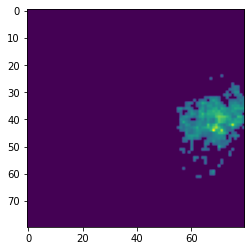

In [18]:
def get_cluster_value(k, labels, values):
    print(values)
    n, m = labels.shape
    ls = []
    for i in range(n):
        for j in range(m):
            if k == labels[i][j]:
                ls.append(values[i][j])
    return np.mean(ls)
                
snr = data['_snr_map.dat']
amp = data['_amp_map.dat']
cluster_snrs = [get_cluster_value(k, labels, data['_snr_map.dat']) for k in range(k_choice)]
for i in range(len(cluster_snrs)):
    if cluster_snrs[i] < cluster_SNRcutoff:
        print("remove cluster", i, "cluster SNR:", cluster_snrs[i])
        snr[labels == i] = 0

snr[snr < SNR_cutoff] = 0
snr[amp < Amp_cutoff] = 0
plt.imshow(snr)

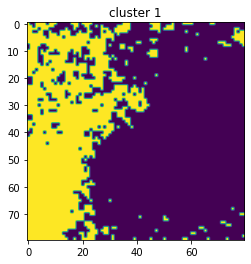

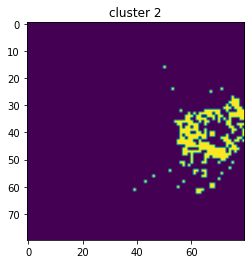

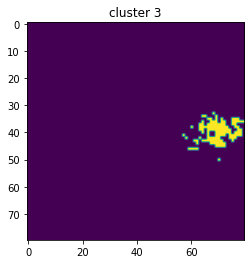

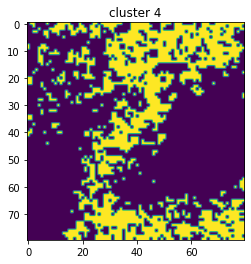

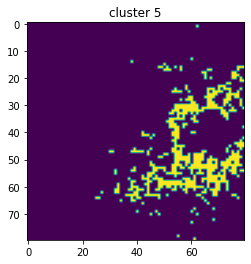

[1, 1, 1, 7, 1, 2, 6, 1, 3, 5, 1, 3, 1, 6, 2, 3, 6, 3, 2, 4, 3, 2, 2, 6, 1, 1, 3, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1]


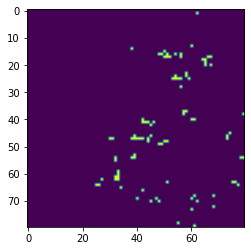

93.0


In [19]:
# pixel size cutoffs

def get_ROI(i, j, snr, visited):
    """ marks all contiguous pixels visited in the process """
    n, m = snr.shape
    visited[i][j] = 1
    if snr[i][j] == 0:
        return []
    roi = [[i, j]]
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            ii = i + dx 
            jj = j + dy
            if 0 <= ii < n and 0 <= jj < m and visited[ii][jj] == 0:
                roi +=  get_ROI(ii, jj, snr, visited)
    return roi
    
n, m = snr.shape
for label in np.unique(labels):
    if label == 0:
        continue
    cluster = (labels == label)
    plt.imshow(cluster)
    plt.title("cluster " + str(label))
    plt.show()

    visited = np.zeros((n, m))
    survivors = []
    for i in range(n):
        for j in range(m):
            if visited[i][j] == 0:
                roi = get_ROI(i, j, cluster, visited)
                if 0 < len(roi) < ROI_px_cutoff:
                    survivors.append(roi)
print([len(s) for s in survivors])
kkm_roi_map = np.zeros((n, m))
for roi in survivors:
    for px in roi:
        i, j = px
        kkm_roi_map[i][j] = 1
        
plt.imshow(kkm_roi_map)
plt.show()
print(np.sum(kkm_roi_map))

[[3140, 3141, 3220], [1916, 1915], [1834], [2388, 2468], [2788, 2868], [3186, 3185, 3187], [3345, 3344], [3182, 3181], [2637], [2712], [2874, 2954], [2313, 2312], [2065], [3350], [2767, 2766], [4029, 4030], [2923, 2843, 2842], [3255, 3254, 3334], [3258, 3259, 3178], [3419, 3499], [4300, 4380, 4381], [4605, 4525, 4606], [3728, 3808, 3727], [3975, 3974], [4209, 4208, 4128], [4212, 4131, 4132], [3880, 3881, 3800], [3796, 3795, 3876], [1888, 1808, 1889], [3240, 3239, 3320], [3161, 3162, 3242], [3483, 3484, 3564, 4432, 4431, 4511], [4978, 4977, 4897, 4827, 4907, 4987, 4906], [3235, 3234, 3154], [3312, 3313, 3393], [5407, 5406, 5487], [5168, 5088, 5089], [2606, 2607, 2687], [3085, 3005, 3006], [3014, 3013, 2933], [2937, 2936, 2856], [2774, 2773, 2693], [2942, 2941, 2861], [3943], [3492, 3493], [3814, 3815], [2211, 2212, 2291], [2454]] 48
[[[20, 39], [21, 39], [20, 40]], [[76, 23], [75, 23]], [[74, 22]], [[68, 29], [68, 30]], [[68, 34], [68, 35]], [[66, 39], [65, 39], [67, 39]], [[65, 41], [6

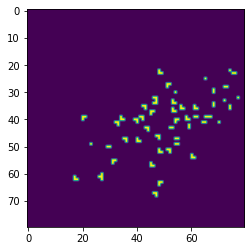

124.0


In [20]:
# read in red labels 
rfr = ROIFileReader(red_rois_filename)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))

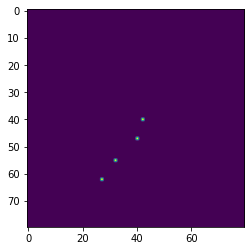

4


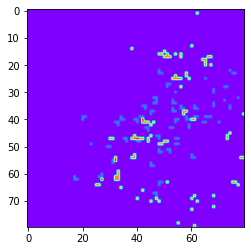

In [21]:
# overlap of red_roi_map and kkm_roi_map
overlap_map = np.logical_and(red_roi_map, kkm_roi_map)
plt.imshow(overlap_map)
plt.show()
print(np.sum(overlap_map))

superpose_map = red_roi_map + kkm_roi_map*5
plt.imshow(superpose_map, cmap='rainbow')